# 编程作业 5 - 偏差和方差

这次练习我们将会看到如何使用课上的方法改进机器学习算法，包括过拟合、欠拟合的的状态判断以及学习曲线的绘制。

In [1]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data():
    """for ex5
    d['X'] shape = (12, 1)
    pandas has trouble taking this 2d ndarray to construct a dataframe, so I ravel
    the results
    """
    d = sio.loadmat('ex5data1.mat')
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])

In [3]:
X, y, Xval, yval, Xtest, ytest = load_data()

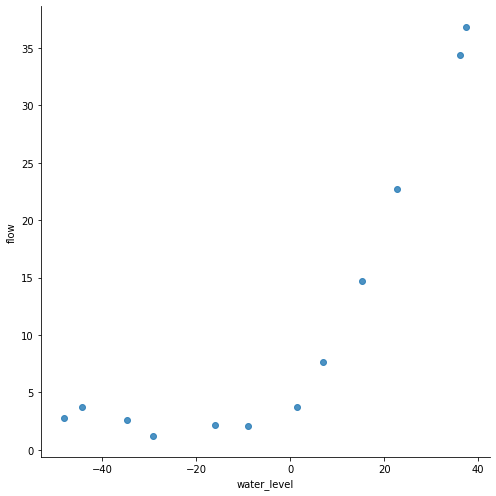

In [5]:
df = pd.DataFrame({'water_level':X, 'flow':y})

sns.lmplot('water_level', 'flow', data=df, fit_reg=False, height=7)
plt.show()

In [6]:
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]
X

array([[  1.        , -15.93675813],
       [  1.        , -29.15297922],
       [  1.        ,  36.18954863],
       [  1.        ,  37.49218733],
       [  1.        , -48.05882945],
       [  1.        ,  -8.94145794],
       [  1.        ,  15.30779289],
       [  1.        , -34.70626581],
       [  1.        ,   1.38915437],
       [  1.        , -44.38375985],
       [  1.        ,   7.01350208],
       [  1.        ,  22.76274892]])

# 代价函数
<img style="float: left;" src="img/linear_cost.png">

In [7]:
def cost(theta, X, y):
# INPUT：参数值theta，数据X,标签y
# OUTPUT：当前参数值下代价函数
# TODO：根据参数和输入的数据计算代价函数
    
    # STEP1：获取样本个数
    # your code here  (appro ~ 1 lines)
    m = X.shape[0]
    
    # STEP2：计算代价函数
    # your code here  (appro ~ 3 lines)
    inner = X @ theta - y
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)

    return cost

In [8]:
theta = np.ones(X.shape[1])
cost(theta, X, y)

303.9515255535976

# 梯度
<img style="float: left;" src="img/linear_gradient.png">

In [9]:
def gradient(theta, X, y):
# INPUT：参数值theta，数据X,标签y
# OUTPUT：当前参数值下梯度
# TODO：根据参数和输入的数据计算梯度  
    
    # STEP1：获取样本个数
    # your code here  (appro ~ 1 lines)
    m = X.shape[0]
    
    # STEP2：计算代价函数
    # your code here  (appro ~ 1 lines)
    
    grad=  (X.T @ (X @ theta - y))/m
    return grad

In [10]:
gradient(theta, X, y)

array([-15.30301567, 598.16741084])

# 正则化梯度与代价函数
<img style="float: left;" src="img/linear_reg_gradient.png">

In [11]:
def regularized_gradient(theta, X, y, l=1):
# INPUT：参数值theta，数据X,标签y
# OUTPUT：当前参数值下梯度
# TODO：根据参数和输入的数据计算梯度 
    
    # STEP1：获取样本个数
    # your code here  (appro ~ 1 lines)
    m = X.shape[0]
    
    # STEP2：计算正则化梯度
    regularized_term = theta.copy()  # same shape as theta
    regularized_term[0] = 0  # don't regularize intercept theta
    # your code here  (appro ~ 1 lines)
    regularized_term = (l / m) * regularized_term

    return gradient(theta, X, y) + regularized_term

In [12]:
regularized_gradient(theta, X, y)

array([-15.30301567, 598.25074417])

In [13]:
def regularized_cost(theta, X, y, l=1):
    m = X.shape[0]

    regularized_term = (l / (2 * m)) * np.power(theta[1:], 2).sum()

    return cost(theta, X, y) + regularized_term

# 拟合数据
> 正则化项 $\lambda=0$

In [14]:
def linear_regression_np(X, y, l=1):
# INPUT：数据X,标签y，正则化参数l
# OUTPUT：当前参数值下梯度
# TODO：根据参数和输入的数据计算梯度 
    # STEP1：初始化参数
    theta = np.ones(X.shape[1])
    
    # STEP2：调用优化算法拟合参数
    # your code here  (appro ~ 1 lines)
    #     参数：
    #     fun ：优化的目标函数
    #     x0 ：初值，一维数组，shape (n,)
    #     args ： 元组，可选，额外传递给优化函数的参数
    #     method：求解的算法，选择TNC则和fmin_tnc()类似
    #     jac：返回梯度向量的函数
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True})
    return res


In [15]:
theta = np.ones(X.shape[0])

final_theta = linear_regression_np(X, y, l=0).get('x')

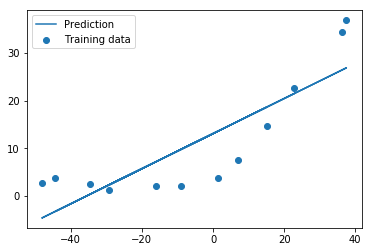

In [16]:
b = final_theta[0] # intercept
m = final_theta[1] # slope

plt.scatter(X[:,1], y, label="Training data")
plt.plot(X[:, 1], X[:, 1]*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

In [17]:
training_cost, cv_cost = [], []

1.使用训练集的子集来拟合应模型

2.在计算训练代价和交叉验证代价时，没有用正则化

3.记住使用相同的训练集子集来计算训练代价

TIP：向数组里添加新元素可使用append函数

In [28]:
# TODO：计算训练代价和交叉验证集代价
# STEP1：获取样本个数，遍历每个样本，逐步计算cost，查看cost曲线。
m = X.shape[0]
for i in range(1, m+1):
    # STEP2：计算当前样本的代价
    res = linear_regression_np(X[:i, :], y[:i], l=0)
    # your code here  (appro ~ 2 lines)
    tc = regularized_cost(res.x, X[:i, :], y[:i], l=0)
    cv = regularized_cost(res.x, Xval, yval, l=0)
    
    # STEP3：把计算结果存储至预先定义的数组training_cost, cv_cost中
    # your code here  (appro ~ 2 lines)
    training_cost.append(tc)
    cv_cost.append(cv)
    

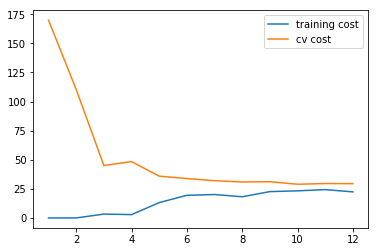

In [29]:
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend(loc=1)
plt.show()

这个模型拟合不太好, **欠拟合了** cv cost 和training cost都很高，对应high bias

# 创建多项式特征

In [30]:
def prepare_poly_data(*args, power):
    """
    args: keep feeding in X, Xval, or Xtest
        will return in the same order
    """
    def prepare(x):
        # 特征映射
        df = poly_features(x, power=power)

        # 归一化处理
        ndarr = normalize_feature(df).as_matrix()

        # 添加偏置项
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)

    return [prepare(x) for x in args]

In [ ]:
# def poly_features(x, power, as_ndarray=False):  #特征映射
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)

    return df.as_matrix() if as_ndarray else df


In [32]:
X, y, Xval, yval, Xtest, ytest = load_data()

In [33]:
poly_features(X, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


# 准备多项式回归数据
1. 扩展特征到 8阶,或者你需要的阶数
2. 使用 **归一化** 来合并 $x^n$ 
3. 不要忘记添加偏置项

In [34]:
def normalize_feature(df):
    """Applies function along input axis(default 0) of DataFrame."""
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [35]:
X_poly, Xval_poly, Xtest_poly= prepare_poly_data(X, Xval, Xtest, power=8)
X_poly[:3, :]

array([[  1.00000000e+00,  -3.62140776e-01,  -7.55086688e-01,
          1.82225876e-01,  -7.06189908e-01,   3.06617917e-01,
         -5.90877673e-01,   3.44515797e-01,  -5.08481165e-01],
       [  1.00000000e+00,  -8.03204845e-01,   1.25825266e-03,
         -2.47936991e-01,  -3.27023420e-01,   9.33963187e-02,
         -4.35817606e-01,   2.55416116e-01,  -4.48912493e-01],
       [  1.00000000e+00,   1.37746700e+00,   5.84826715e-01,
          1.24976856e+00,   2.45311974e-01,   9.78359696e-01,
         -1.21556976e-02,   7.56568484e-01,  -1.70352114e-01]])

# 画出学习曲线
> 首先，我们没有使用正则化，所以 $\lambda=0$

In [38]:
def plot_learning_curve(X, y, Xval, yval, l=0):
# INPUT：训练数据集X,y，交叉验证集Xval，yval，正则化参数l
# OUTPUT：当前参数值下梯度
# TODO：根据参数和输入的数据计算梯度 
    
    # STEP1：初始化参数，获取样本个数，开始遍历
    training_cost, cv_cost = [], []
    m = X.shape[0]
    for i in range(1, m + 1):
        # STEP2：调用之前写好的拟合数据函数进行数据拟合
        # your code here  (appro ~ 1 lines)
        res = linear_regression_np(X[:i, :], y[:i], l=l)
        # STEP3：计算样本代价
        # your code here  (appro ~ 1 lines)
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)
        # STEP3：把计算结果存储至预先定义的数组training_cost, cv_cost中
        # your code here  (appro ~ 2 lines)
        training_cost.append(tc)
        cv_cost.append(cv)

        

    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    plt.legend(loc=1)


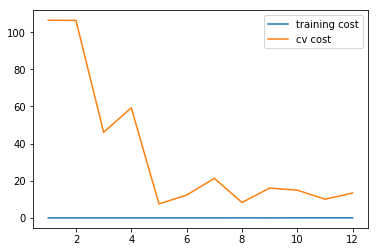

In [39]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=0)
plt.show()

你可以看到训练的代价太低了，不真实. 这是 **过拟合**了

# try $\lambda=1$

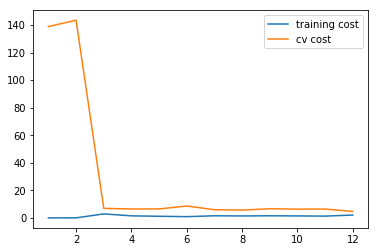

In [40]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=1)
plt.show()


训练代价增加了些，不再是0了。
也就是说我们减轻**过拟合**

# try $\lambda=100$

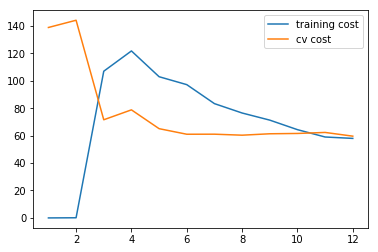

In [41]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=100)
plt.show()

太多正则化了.  
变成 **欠拟合**状态

# 找到最佳的 $\lambda$

In [42]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

In [43]:
for l in l_candidate:
    res = linear_regression_np(X_poly, y, l)
    
    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)
    
    training_cost.append(tc)
    cv_cost.append(cv)

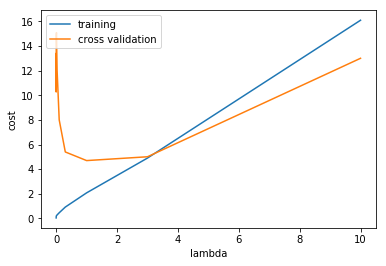

In [44]:
plt.plot(l_candidate, training_cost, label='training')
plt.plot(l_candidate, cv_cost, label='cross validation')
plt.legend(loc=2)

plt.xlabel('lambda')

plt.ylabel('cost')
plt.show()

In [45]:
# best cv I got from all those candidates
l_candidate[np.argmin(cv_cost)]

1

In [46]:
# use test data to compute the cost
for l in l_candidate:
    theta = linear_regression_np(X_poly, y, l).x
    print('test cost(l={}) = {}'.format(l, cost(theta, Xtest_poly, ytest)))

test cost(l=0) = 10.122298845834932
test cost(l=0.001) = 10.989357236615056
test cost(l=0.003) = 11.26731092609127
test cost(l=0.01) = 10.881623900868235
test cost(l=0.03) = 10.02232745596236
test cost(l=0.1) = 8.632062332318977
test cost(l=0.3) = 7.336513212074589
test cost(l=1) = 7.466265914249742
test cost(l=3) = 11.643931713037912
test cost(l=10) = 27.7150802906621


调参后， $\lambda = 0.3$ 是最优选择，这个时候测试代价最小